In [113]:
# This script introduces PTQ (post-training quantization). 
# Taken a small CNN model of 5 layers for image classication on CIFAR-10 dataset as an example, 
# it demonstrates how to quantize the model parameters, both weight and bias and activations.

In [114]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

batchsize=4
data_dir = "./data"
num_workers=1
lr=0.001
momentum=0.9
epoches=2

# 设置量化位宽
bitwidth_A = 4
bitwidth_W = 4
bitwidth_B = 4


In [115]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root = data_dir+'/train',train=True,
                                        download = True,transform = transform)
testset = torchvision.datasets.CIFAR10(root = data_dir+'/test',train = False,
                                       download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, 
                                          batch_size =  batchsize, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, 
                                         batch_size = batchsize, num_workers=num_workers)



Files already downloaded and verified
Files already downloaded and verified


In [117]:
# Define a simple CNN that classifies CIFAR images.
# The network provided is similar to LeNet-5, and it has the following architecture:

# **Layer** |     **Type**    | **Input Shape** | **Output Shape** | **Activation**
#   conv1   |  Convolutional  |     3x32x32     |     6x28x28      |      ReLU 
#   pool1   |     Max pool    |     6x28x28     |     6x14x14      |      None                
#   conv2   |  Convolutional  |     6x14x14     |     16x10x10     |      ReLU                
#   pool2   |     Max pool    |     16x10x10    |     16x5x5       |      None                
#   fc1     | Fully-connected |       400       |       120        |      ReLU                
#   fc2     | Fully-connected |       120       |       84         |      ReLU                
#   fc3     | Fully-connected |       84        |       10         |      None                

# None of the layers in the network have a bias associated with them.
# This makes them easier to quantize.
# Towards the end of this assignment, we will add biases to the final layer and quantize it as well.
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5,bias = False)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5,bias = False)
        self.fc1 = nn.Linear(400,120,bias = False)
        self.fc2 = nn.Linear(120,84,bias = False)
        self.fc3 = nn.Linear(84,10,bias = False)
    
    def forward(self,x: torch.Tensor) ->  torch.Tensor:
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [118]:
def train(model:nn.Module, dataloader:torch.utils.data.DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr=lr,momentum=momentum)
    for epoch in range(epoches):
        train_loss=0
        for i,data in enumerate(dataloader):
            # get inputs and labels
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            #forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #print statistics
            train_loss+=loss.item()
            if(i%2000==1999):
                print('[%d, %d] loss = %.3f'%
                      (epoch+1,i+1,train_loss/2000))
                train_loss=0
    print('Finishing Training')

def test(model:nn.Module, dataloader:torch.utils.data.DataLoader,max_samples=None)->float:
    total=0
    correct=0
    n_inference=0
    with torch.no_grad():
        for i,data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            ___ , predicted = torch.max(outputs,dim=1)
            total+=labels.size(0)
            correct += (predicted==labels).sum().item()
            
            if max_samples:
                n_inference += inputs.shape[0]
                if(n_inference > max_samples):
                    break
    return 100 * correct / total

In [119]:
net=Net().to(device)
train(net,trainloader)

[1, 2000] loss = 2.215
[1, 4000] loss = 1.866
[1, 6000] loss = 1.712
[1, 8000] loss = 1.620
[1, 10000] loss = 1.554
[1, 12000] loss = 1.490
[2, 2000] loss = 1.432
[2, 4000] loss = 1.411
[2, 6000] loss = 1.401
[2, 8000] loss = 1.355
[2, 10000] loss = 1.333
[2, 12000] loss = 1.320
Finishing Training


In [120]:
score = test(net,testloader)
print("Accuracy of the network on test images:{}%".format(score))

Accuracy of the network on test images:54.23%


In [121]:
# Quantization of the model add more parameters to the model, such as zero_point, scale, etc.
# Define a function to copy the model and parameters we specifically add to the model.

from copy import deepcopy

def copy_model(model:nn.Module)->nn.Module:
    result=deepcopy(model)
    if(hasattr(model,'input_activations')):
        result.input_activations = deepcopy(model.input_activations)
    
    for result_layer, original_layer in zip(result.children(),model.children()):
        if(isinstance(result_layer,nn.Conv2d) or isinstance(result_layer,nn.Linear)):
            if(hasattr(original_layer.weight,'scale')):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if(hasattr(original_layer,'activations')):
                result_layer.activations = deepcopy(original_layer.activations)
            if(hasattr(original_layer,'output_scale')):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [122]:
# Question 1: Visualize Weights

conv1:the range is [-0.60555,0.53042]
conv1: the 3-sigma range is [-0.61721, 0.61377]
aver: -0.0017223925


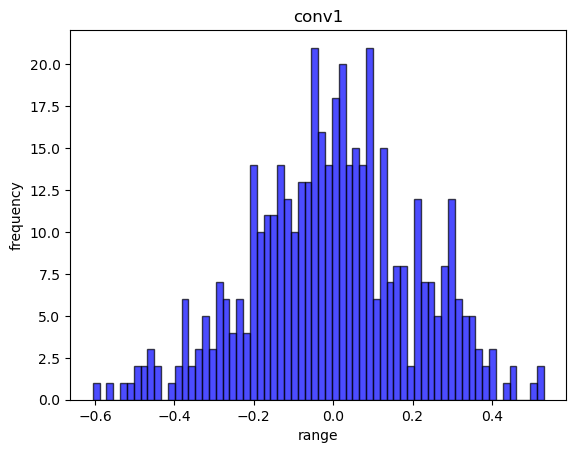

conv2:the range is [-0.44271,0.50166]
conv2: the 3-sigma range is [-0.35755, 0.33185]
aver: -0.012847105


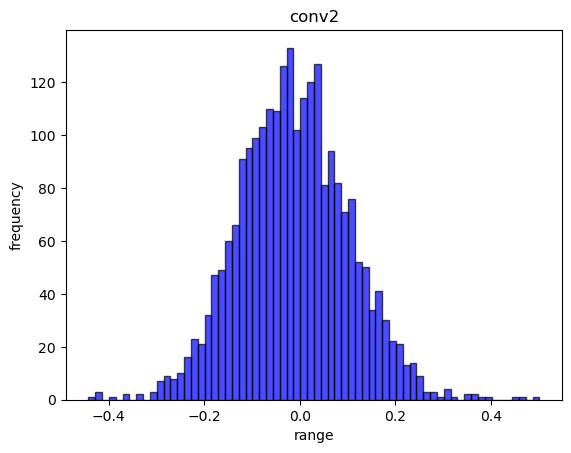

fc1:the range is [-0.27534,0.27179]
fc1: the 3-sigma range is [-0.13319, 0.12777]
aver: -0.0027137613


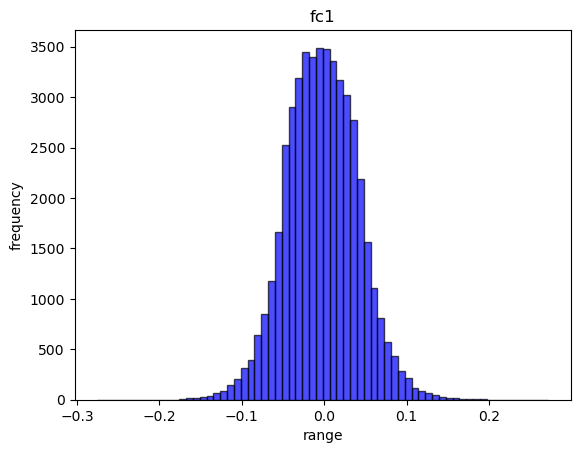

fc2:the range is [-0.22933,0.23890]
fc2: the 3-sigma range is [-0.19521, 0.19069]
aver: -0.0022635118


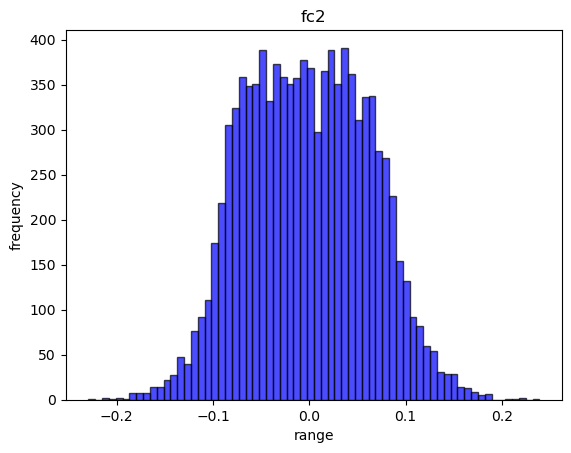

fc3:the range is [-0.42948,0.37127]
fc3: the 3-sigma range is [-0.38350, 0.37379]
aver: -0.0048571024


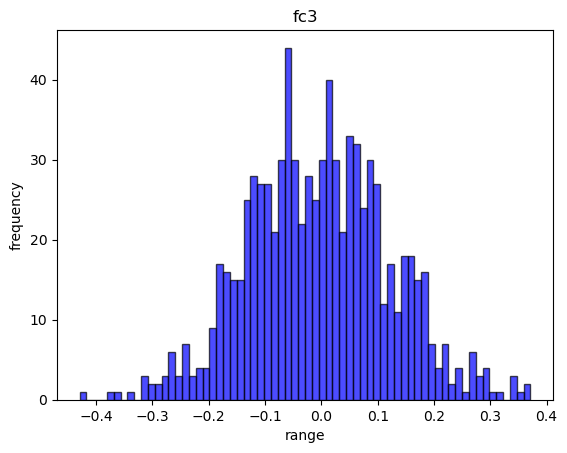

In [123]:
## Question 1.1:

import matplotlib.pyplot as plt
import numpy as np

name=['conv1','conv2','fc1','fc2','fc3']
n = 0

for layer in net.children():
    if isinstance(layer,nn.Conv2d) or isinstance(layer, nn.Linear):
        weight =  layer.weight.data.view(-1).cpu().numpy()
        print(name[n]+":the range is [{:.5f},{:.5f}]".format(weight.min(),weight.max()))

        # find 3-sigma range(u-3s,u+3s)
        mu = np.mean(weight)
        sigma = np.std(weight)
        #out_per = np.sum(np.abs(weight-mu)>3*np.sqrt(sigma))/np.size(weight)
        #sigma3 = int (np.size(weight)*0.0027)
        #sigma3_value = np.abs(weight)[np.argpartition(np.abs(weight),-sigma3)[-sigma3]]
        #print(name[n] + ": the 3-sigma range is [{:.5f}, {:.5f}]".format(max(-sigma3_value, weight.min()), min(sigma3_value,weight.max())))
        print(name[n] + ": the 3-sigma range is [{:.5f}, {:.5f}]".format(mu-3*sigma,mu+3*sigma))
        print("aver:",mu)
        plt.hist(weight, bins=66, facecolor="blue", edgecolor="black", alpha=0.7) # 画直方图
        plt.xlabel("range")
        plt.ylabel("frequency")
        plt.title(name[n])
        plt.show()
        n += 1

In [124]:
## Question 1.2: Explain which range you would prefer to use if you were to quantize each layer's weights and wanted to strike a balance between the range of values that could be expressed, and your precision.

In [125]:
# Question 2: Quantize Weights
net_q2 = copy_model(net)

In [126]:
## Question 2.1:

from typing import Tuple
# 确定scale进行量化
def quantized_weights(weights: torch.Tensor, bitwidth_W: int, range_sigma3: bool = True) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights
    bitwidth_W (int): The number of bits to use for each weight.
    range_sigma3 (bool): Whether to use the 3-sigma range or the absolute range.

    Returns:
    (Tensor, float): A tuple with the following elements:
                * The weights in quantized form, where every value is an integer, e.g., 8 bit between -128 and 127.
                The "dtype" will still be "float", but the values themselves should all be integers.
                * The scaling factor that your weights were multiplied by.
                This value does not need to be an 8-bit integer. Usually it's a float.
    '''

    # modify the following code to try other range

    W_border = 2**(bitwidth_W-1)
    if range_sigma3:#use 3-sigma range
      #sigma3 = int(np.size(w)*0.0027)
      #sigma3_value = np.abs(w)[np.argpartition(np.abs(w), -sigma3)[-sigma3]] 
      r_max = 3*torch.std(weights)
      if(r_max>torch.max(torch.abs(weights))):
        r_max = torch.max(torch.abs(weights))

    else:# use absolute range
      r_max = torch.max(torch.abs(weights))

    S = r_max/W_border
    q = torch.round(weights/S)

    return torch.clamp(q, min=-W_border, max=W_border-1) , S



In [127]:
def quantize_layer_weights(model: nn.Module, bitwidth_W: int,range_sigma3: bool=False):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data, bitwidth_W, range_sigma3)
            q_layer_data = q_layer_data.to(device)
            quantization_error = torch.mean(torch.abs(layer.weight.data - q_layer_data*scale)).item()
            print("Quantizaton error of {} layer is: ".format(layer.__class__.__name__), quantization_error)
            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -2**(bitwidth_W-1)).any() or (q_layer_data > (2**(bitwidth_W-1)-1)).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for a {} bit signed integer ".format(layer.__class__.__name__, bitwidth_W))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2, bitwidth_W,range_sigma3=False)


Quantizaton error of Conv2d layer is:  0.01847127079963684
Quantizaton error of Conv2d layer is:  0.015920933336019516
Quantizaton error of Linear layer is:  0.00857261661440134
Quantizaton error of Linear layer is:  0.007431983947753906
Quantizaton error of Linear layer is:  0.013118750415742397


In [128]:
## Question 2.2:

# Record the accuracy change of the network after quantizing its weights. If you’ve done everything correctly, the accuracy change should be negligible.

score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 52.01%


In [129]:
# Question 3: Visualize Activations

# Now that we have quantized the weights of the CNN, we must also quantize the activations (inputs and outputs to layers) traveling through it.
# But before doing so, let's analyze what values the activations take when travelling through the network.

# We provide convenience code which will record the values of every pixel of the outputs and inputs travelling through the neural network.
# (This is the initial CNN, where not even the weights had yet been quantized).
# We then profile these values when running on a subset of the training set.

In [130]:
# The code below will record the activations of the input and output of each layer of the network.
# It uses PyTorch's hook mechanism to record the activations of each layer.
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)
    
    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)
    

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [131]:
# Use the unquantized model to profile input and output activations on a subset of the training dataset.

net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400) # Don't use testloader here, since PTQ uses the training data to profile activations
net_q3.profile_activations = False

input_activations: the range is [-1.00000, 1.00000]
input_activations: the 3-sigma range is [-1.54056, 1.42167]


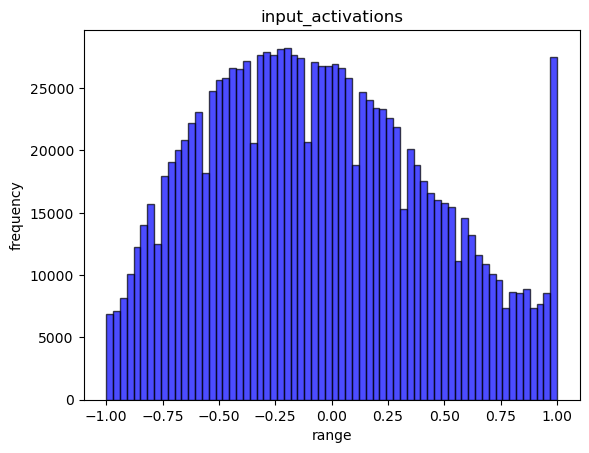

conv1: the range is [0.00000, 8.86724]


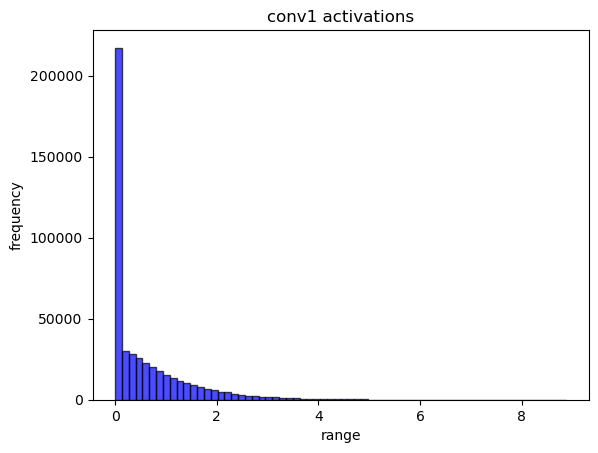

conv2: the range is [0.00000, 12.72279]


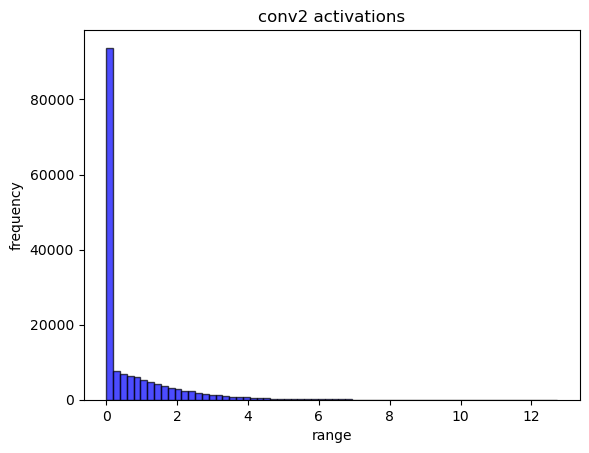

fc1: the range is [0.00000, 12.77988]


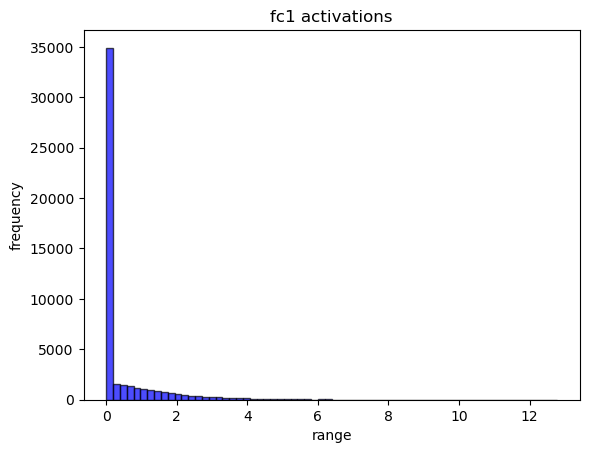

fc2: the range is [0.00000, 6.89837]


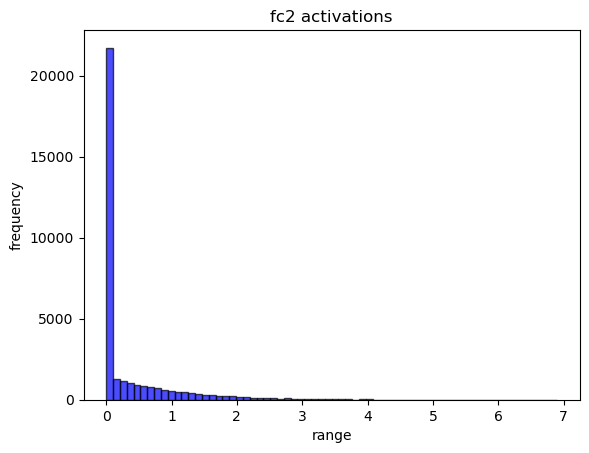

fc3: the range is [-7.80871, 7.09802]


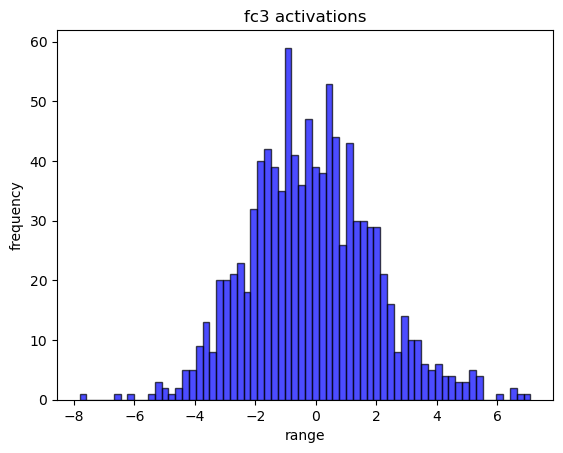

In [132]:
## Question 3.1:

# Plot histograms of the input images and the outputs of every convolutional and fully-connected layer. 
# Record any observations you make about the distribution of the values.
# ADD YOUR CODE HERE 
Activation_border = 2**(bitwidth_A-1)
input_activations = net_q3.input_activations 
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

# to plot distributions of activations
# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:

#   input_activations
print( "input_activations"+ ": the range is [{:.5f}, {:.5f}]".format(input_activations.min(), input_activations.max()))
#sigma3 = int(np.size(input_activations)*0.0027) 
#sigma3_value = np.abs(input_activations)[np.argpartition(np.abs(input_activations), -sigma3)[-sigma3]]
#print("input_activations"+ ": the 3-sigma range is [{:.5f}, {:.5f}]".format(max(-sigma3_value, input_activations.min()), min(sigma3_value,input_activations.max())))

u = np.mean(input_activations)
sigma = np.std(input_activations)
print("input_activations"+ ": the 3-sigma range is [{:.5f}, {:.5f}]".format(u-3*sigma,u+3*sigma))


plt.hist(input_activations, bins=66, facecolor="blue", edgecolor="black", alpha=0.7)
plt.xlabel("range")
plt.ylabel("frequency")
plt.title("input_activations")
plt.show()
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activations

name = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
n = 0
for layer in net_q3.children(): # 遍历类的成员
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        acti = layer.activations
        print(name[n] + ": the range is [{:.5f}, {:.5f}]".format(acti.min(), acti.max()))
        # sigma3 = int(np.size(acti)*0.0027) 
        # sigma3_value = np.abs(acti)[np.argpartition(np.abs(acti), -sigma3)[-sigma3]]
        # print(name[n] + ": the 3-sigma range is [{:.5f}, {:.5f}]".format(max(-sigma3_value, acti.min()), min(sigma3_value,acti.max())))
        plt.hist(acti, bins=66, facecolor="blue", edgecolor="black", alpha=0.7) # 画直方图
        plt.xlabel("range")
        plt.ylabel("frequency")
        plt.title(name[n]+" activations")
        plt.show()
        n += 1



In [133]:
## Question 3.2:

# Additionally, record the range of the values, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
# For which layers is the 3-sigma range larger or smaller than the actual range?
# Then explain which range you would prefer to use if you were to quantize each layer's weights and wanted to strike a balance between the range of values that could be expressed, and your precision.
# Remember that you are plotting the activations *after* activation functions like ReLU have been applied, which means that you should not be worried if you find that your plots are asymmetric.

In [134]:
# Question 4: Quantize Activations

# Complete the `quantize_initial_input` and `quantize_activations` functions which calculate the scaling factors for the initial image which is input to the CNN, and the outputs of each layer, respectively.

# complete the `forward` function for the `NetQuantized` class.
# You will have to add code here to scale the outputs of each layer, and then to clamp the outputs of each layer to integers between -128 and 127 afterwards.


In [135]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module, bitwidth_A:int):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)
        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        self.input_act_border = 2**(bitwidth_A-1)
        self.act_border = 2**(bitwidth_A)-1

        # for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
        #     #逐层遍历,检查量化是否成功
        #     def pre_hook(l, x):
        #         x = x[0]
        #         #异常处理:检查之前的量化是否将所有的数转化进规定的区间
        #         if (x < -self.activation_border).any() or (x > (self.activation_border-1)).any():
        #             raise Exception("Input to {} layer is out of bounds for an {}-bit signed integer".format(l.__class__.__name__, bitwidth_A))
        #         if (x != x.round()).any():
        #             raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

        #     layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_scale = NetQuantized.quantize_initial_input(
            net_with_weights_quantized.input_activations, bitwidth_A)
        
        # Calculate the output scaling factors for all the layers of the CNN

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.quantize_scale = NetQuantized.quantize_activations(layer.activations, bitwidth_A)


        self.conv1.output_scale = self.input_scale*self.conv1.weight.scale/self.conv1.quantize_scale
        self.conv2.output_scale = self.conv1.quantize_scale*self.conv2.weight.scale/self.conv2.quantize_scale
        self.fc1.output_scale = self.conv2.quantize_scale*self.fc1.weight.scale/self.fc1.quantize_scale
        self.fc2.output_scale = self.fc1.quantize_scale*self.fc2.weight.scale/self.fc2.quantize_scale


    @staticmethod
    def quantize_initial_input(inputs, bitwidth_A:int):
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        
        '''

        #sigma3 = int(np.size(pixels)*0.0027)
        #sigma3_value = pixels[np.argpartition(pixels,-sigma3)[-sigma3]]
        A_border = 2**(bitwidth_A-1)
        r_max = np.max(np.abs(inputs))
        S = r_max/A_border

        return S

    @staticmethod
    def quantize_activations(layer_out_acti: np.ndarray, bitwidth_A: int) -> float:
        '''
        Calculate the scaling factor of the activations

        Parameters:
        layer_out_acti (ndarray): The values of all the pixels which have been output by this layer during training
        '''

        # ADD YOUR CODE HERE
        A_border = 2**(bitwidth_A)-1
        S = np.max(layer_out_acti)/A_border
        return S

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        x = x/self.input_scale 
        x = torch.clamp(x.round(), min=-self.input_act_border, max=self.input_act_border-1)

        x = self.pool(F.relu(self.conv1(x)))
        x = x*self.conv1.output_scale
        x = torch.clamp(x.round(), min=0, max=self.act_border)

        x = self.pool(F.relu(self.conv2(x)))
        x = x*self.conv2.output_scale
        x = torch.clamp(x.round(), min=0, max=self.act_border)     

        x = x.view(-1, 16 * 5 * 5)
        
        x = F.relu(self.fc1(x))   
        x = x*self.fc1.output_scale
        x = torch.clamp(x.round(), min=0, max=self.act_border)  

        x = F.relu(self.fc2(x))   
        x = x*self.fc2.output_scale
        x = torch.clamp(x.round(), min=0, max=self.act_border)   
        
        if self.fc3.bias is not None:
            w=self.fc3.weight.data
            b=self.fc3.bias.data
            x = F.linear(x, w, b*self.fc3.scale)
        else:
            x = self.fc3(x)

        return x


In [136]:
# Merge the information from net_q2 and net_q3 together
#weight quantization & activation quantization 
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init, bitwidth_A)



In [137]:
# Finally, record the accuracy of your network after both weights and activations have been quantized.
# If you've done everything right, you should still find almost no accuracy change.

score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))


Accuracy of the network after quantizing both weights and activations: 51.29%


In [138]:
# Question 5: Quantize Biases

# Let us now update our CNN to include a bias in its final layer, *fc3*.
# We have already included code to create and train a new CNN called `net_with_bias`.

# Consider how a bias affects the equation for an unquantized layer:



In [139]:
## Question 5.1:

# Suppose that we again quantized a biased layer with the same scaling factors we used in previous questions: $n_W$, $n_{In}$, and $n_{Out}$.
# What would we scale bias by in this case?
# Write an equation in your lab report to describe the output of the quantized layer with a bias.

# Create a new network with a bias on *fc3*.


In [140]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias = True) # Add a bias to the final layer
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [141]:
train(net_with_bias, trainloader)

[1, 2000] loss = 2.197
[1, 4000] loss = 1.883
[1, 6000] loss = 1.700
[1, 8000] loss = 1.591
[1, 10000] loss = 1.537
[1, 12000] loss = 1.495
[2, 2000] loss = 1.443
[2, 4000] loss = 1.415
[2, 6000] loss = 1.376
[2, 8000] loss = 1.371
[2, 10000] loss = 1.353
[2, 12000] loss = 1.326
Finishing Training


In [142]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 51.96%


In [143]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [144]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights,bitwidth_W)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Quantizaton error of Conv2d layer is:  0.018421584740281105
Quantizaton error of Conv2d layer is:  0.012926523573696613
Quantizaton error of Linear layer is:  0.007661085110157728
Quantizaton error of Linear layer is:  0.007701331749558449
Quantizaton error of Linear layer is:  0.014926733449101448
Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 45.85%


In [145]:
# Fill in the `quantized_bias` function in the `NetQuantizedWithBias` class.
# This function is meant to quantize the bias on the final layer of the CNN.

In [146]:
class NetQuantizedWithBias(NetQuantized): # it is a subclass of NetQuantized, which alreay has quantized weights and activations
    def __init__(self, net_with_weights_quantized: nn.Module, bitwidth:int):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized, bitwidth)

        self.fc3.bias.data,self.fc3.scale = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data, bitwidth, self.fc3.weight.scale)
        
        B_border = 2**(bitwidth-1)
        if (self.fc3.bias.data < -B_border).any() or (self.fc3.bias.data > B_border-1).any():
            raise Exception("Bias has values which are out of bounds")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, bitwidth_B:int, weight_scale) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between MIN_32B_SINT and MAX_32B_SINT.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between MIN_32B_SINT and MAX_32B_SINT.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # ADD YOUR CODE HERE
        B_border = 2**(bitwidth_B-1) 
        bias_scale = (torch.max(torch.abs(bias)))/B_border
        bias = torch.round(bias/bias_scale)
        bias = torch.clamp(bias, min=-B_border, max=B_border-1)
        return bias, bias_scale/weight_scale


In [147]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights, bitwidth_B)

In [148]:
## Question 5.3:

# What is your accuracy before and after quantizing CNN with the bias?
# The accuracy change should ideally be negligible.

In [149]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights, bias and activations are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights, bias and activations are quantized: 49.69%
